<a href="https://colab.research.google.com/github/Joaquim-mph/Joaquim-mph/blob/main/Tarea3Tutorial_HandCrafted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HandCrafted Crack Segmentation

## 1. Libraries

In [ ]:
import cv2
import tqdm
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
import time

## 2. Mount Drive to load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## 3. Images

In [ ]:
test_path = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/'
test_txt = open('/content/drive/MyDrive/crack_segmentation_dataset/test/test_small.txt', 'r')
lines = test_txt.readlines()
test_paths = []
for line in lines:
  test_paths.append(test_path+line.strip()+'.jpg')

In [ ]:
test_paths[0] # Es normal si la imagen termina en .jpg.jpg, es error del dataset pero no afecta la lectura de la imagen

'/content/drive/MyDrive/crack_segmentation_dataset/test/images/noncrack_noncrack_concrete_wall_96_2.jpg.jpg'

## 4. Metrics

In [ ]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def intersection_over_union(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / (np.sum(union) + 1e-8)
    return iou_score

## 5. Algoritmo

In [ ]:
def segment_cracks(image_path, vis = False):
    # Read the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Read mask
    mask_path = image_path.replace('images', 'masks')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.bilateralFilter(image, d=15, sigmaColor=75, sigmaSpace=75)

    # Usar umbralización adaptativa
    #thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                               cv2.THRESH_BINARY_INV, 11, 2)
    _,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Use Canny edge detection to find edges
    edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

    # Use morphological operations to close gaps in cracks
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours of the segmented cracks
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an output image to draw contours
    output = np.zeros_like(image)

    # Draw contours on the output image
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small areas
            cv2.drawContours(output, [contour], -1, 255, thickness=cv2.FILLED)

    if vis:
      # Display the results
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 6, 1)
      plt.title('Original Image')
      plt.imshow(image, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 2)
      plt.title('Mask')
      plt.imshow(mask, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 3)
      plt.title('Blurred Image')
      plt.imshow(blurred, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 4)
      plt.title('Thresholded Image')
      plt.imshow(thresh, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 5)
      plt.title('Edge Detection')
      plt.imshow(edges, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 6)
      plt.title('Segmented Cracks')
      plt.imshow(output, cmap='gray')
      plt.axis('off')

      plt.tight_layout()
      plt.show()

    return closed, mask

## 6. Loop

In [ ]:
accs = []
ious = []
for pdx, path in enumerate(tqdm.tqdm(test_paths)):
  #if pdx < 10:
  #  continue
  result, mask = segment_cracks(path)
  acc = accuracy_score(mask, result)
  iou = intersection_over_union(mask, result)
  accs.append(acc)
  ious.append(iou)
  #break

100%|██████████| 169/169 [00:12<00:00, 13.03it/s]


In [ ]:

# print mean accuracy and mean iou in %
print(f"Mean accuracy: {np.mean(accs) * 100:.2f}%")
print(f"Mean IoU: {np.mean(ious) * 100:.2f}%")

Mean accuracy: 54.62%
Mean IoU: 8.48%


# La idea es maximizar el mean accuracy y el mean IoU, pero este es un problema complejo, no se asuste si no logra resultados "decentes"

# Inference time

In [ ]:
# Choose an image path from our small test set
image_path = test_paths[10]

# Measure inference time without visualization
start_time = time.time()
result, mask = segment_cracks(image_path, vis=False)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")


Inference time for segment_cracks: 0.0700 seconds


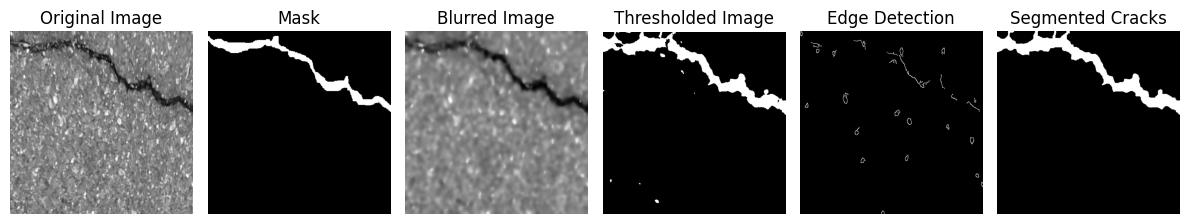

Inference time for segment_cracks: 0.7519 seconds


In [ ]:
# Choose an image path from our small test set
image_path = test_paths[10]

# Measure inference time with visualization
start_time = time.time()
result, mask = segment_cracks(image_path, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")
